# Stereo Disparity from DeepSeek

Size of the padded left image (h, w) (512, 743)
Size of the padded right image (h, w) (512, 743)
Size of the padded left image (h, w) (512, 743)
Size of the padded right image (h, w) (512, 743)


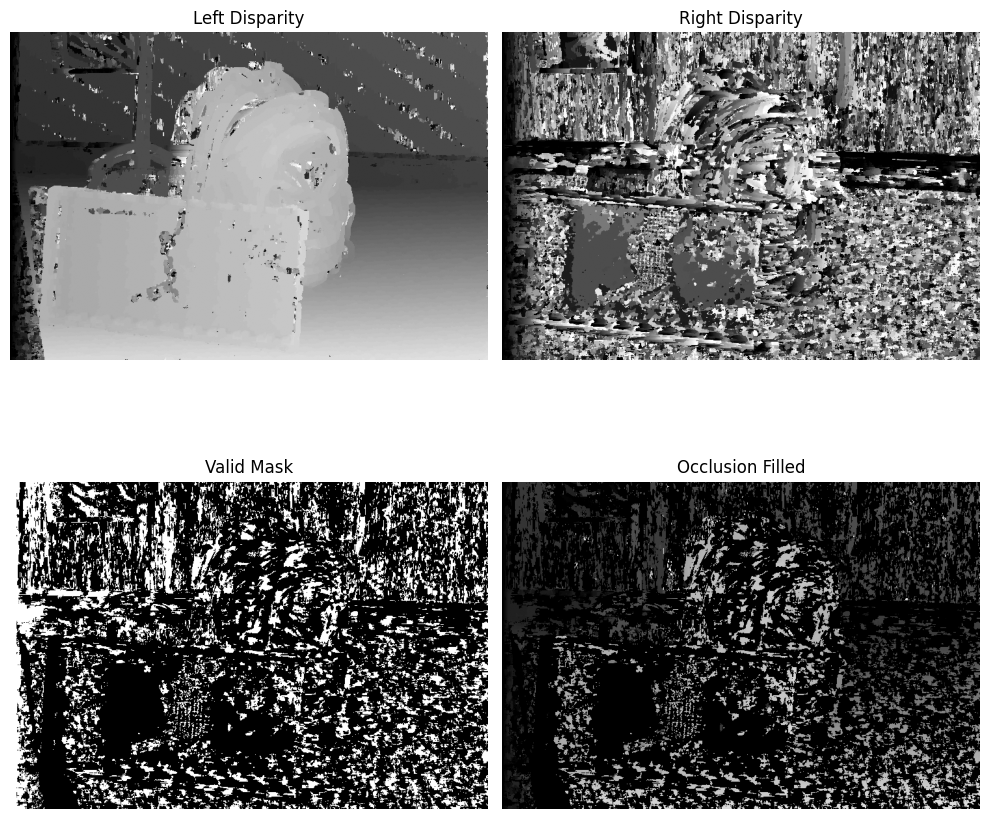

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def zncc(left_patch, right_patch):
    """Compute ZNCC between two patches"""
    left_mean = np.mean(left_patch)
    right_mean = np.mean(right_patch)

    numerator = np.sum((left_patch - left_mean) * (right_patch - right_mean))
    denominator = np.sqrt(np.sum((left_patch - left_mean)**2) * np.sum((right_patch - right_mean)**2))

    return numerator / (denominator + 1e-6)  # Add small epsilon to avoid division by zero

def compute_disparity_map(left_img, right_img, window_size=9, max_disp=64):
    """Compute disparity map using ZNCC"""
    h, w = left_img.shape
    disparity_map = np.zeros((h, w), dtype=np.float32)
    pad = window_size // 2

    # Pad images to handle borders
    left_padded = cv2.copyMakeBorder(left_img, pad, pad, pad, pad, cv2.BORDER_REFLECT)
    right_padded = cv2.copyMakeBorder(right_img, pad, pad, pad, pad, cv2.BORDER_REFLECT)
    print(f"Size of the padded left image (h, w) {left_padded.shape}")
    print(f"Size of the padded right image (h, w) {right_padded.shape}")

    for y in range(pad, h + pad): # y is from 4 to 507
        for x in range(pad, w + pad): # x is from 4 to 738
            best_d = 0
            max_zncc = -np.inf

            # Extract left window
            #iter 1: left_padded[0:9, 0:9]
            #iter 2: left_padded[0:9, 1:10]
            #iter 2: left_padded[0:9, 2:11]
            #iter last: left_padded[0:9, 734:743]
            left_window = left_padded[y-pad:y+pad+1, x-pad:x+pad+1]

            # Search disparities
            # range (0, min(64, x-4))
            # range(0, 0)
            # range(0, 1)
            # range(0, 2)
            #x = 10, d = range (0, min(64, 6)) = range(0, 6) = 0, 1, 2, 3, 4, 5
            # right_padded[0:9, (10-d)-4:(10-d)+4+1]
            # right_padded[0:9, 6:15]
            # right_padded[0:9, 5:14] ...
            # right_padded[0:9, 1:10]
            for d in range(0, min(max_disp, x-pad)):  # Ensure valid x-d
                # Extract right window (shifted by d)
                right_window = right_padded[y-pad:y+pad+1, (x-d)-pad:(x-d)+pad+1]

                if right_window.shape != (window_size, window_size):
                    continue  # Skip invalid windows

                corr = zncc(left_window, right_window)

                if corr > max_zncc:
                    max_zncc = corr
                    best_d = d

            disparity_map[y-pad, x-pad] = best_d

    return disparity_map

# Example usage
left_image = "/content/drive/MyDrive/Colab Notebooks/Multiprocessor Programming/im0.png"
right_image = "/content/drive/MyDrive/Colab Notebooks/Multiprocessor Programming/im1.png"

left_img = cv2.imread(left_image, cv2.IMREAD_GRAYSCALE).astype(np.float32)
right_img = cv2.imread(right_image, cv2.IMREAD_GRAYSCALE).astype(np.float32)

# Resize for testing (original size: 2940x2016 (WxH) -> 735x504)
left_img = cv2.resize(left_img, (735, 504))
right_img = cv2.resize(right_img, (735, 504))

# Compute disparity map (small max_disp for testing)
disp_left = compute_disparity_map(left_img, right_img, window_size=9, max_disp=64)
disp_right = compute_disparity_map(right_img, left_img, window_size=9, max_disp=64)

# Post-processing
def cross_check(disp_left, disp_right, threshold=8):
    """Cross-checking consistency validation"""
    h, w = disp_left.shape
    valid_mask = np.zeros((h, w), dtype=bool)

    for y in range(h):
        for x in range(w):
            if x - disp_left[y, x] >= 0:
                right_d = disp_right[y, int(x - disp_left[y, x])]
                if abs(disp_left[y, x] - right_d) <= threshold:
                    valid_mask[y, x] = True
    return valid_mask

valid_mask = cross_check(disp_left, disp_right, threshold=8)
disp_combined = disp_left * valid_mask  # Zero out invalid pixels


# Save disp_left and disp_right directly.
plt.imsave("disp_left.png", disp_left, cmap='gray')
plt.imsave("disp_right.png", disp_right, cmap='gray')

# For valid_mask (boolean), convert to 0 and 255 (uint8) for proper saving.
plt.imsave("valid_mask.png", (valid_mask.astype(np.uint8) * 255), cmap='gray')

# Save disp_combined (e.g., occlusion filled) image.
plt.imsave("disp_combined.png", disp_combined, cmap='gray')

# Visualize
plt.figure(figsize=(10, 10))

# First subplot for disp_left
plt.subplot(2, 2, 1)  # Arguments: nrows=2, ncols=2, index=1
plt.imshow(disp_left, cmap='gray')  # Use cmap='gray' if the image is grayscale
plt.title("Left Disparity")
plt.axis('off')  # Hide axis ticks

# Second subplot for disp_right
plt.subplot(2, 2, 2)  # index=2
plt.imshow(disp_right, cmap='gray')
plt.title("Right Disparity")
plt.axis('off')

# Third subplot for valid_mask
plt.subplot(2, 2, 3)  # index=3
plt.imshow(valid_mask, cmap='gray')
plt.title("Valid Mask")
plt.axis('off')

# Fourth subplot for occlusion_filled_img
plt.subplot(2, 2, 4)  # index=4
plt.imshow(disp_combined, cmap='gray')
plt.title("Occlusion Filled")
plt.axis('off')

# Automatically adjust subplot parameters for a neat layout.
plt.tight_layout()
plt.savefig("my_figure.png", dpi=300, bbox_inches='tight')

# Display the figure with subplots
plt.show()


### Occlusion Filling

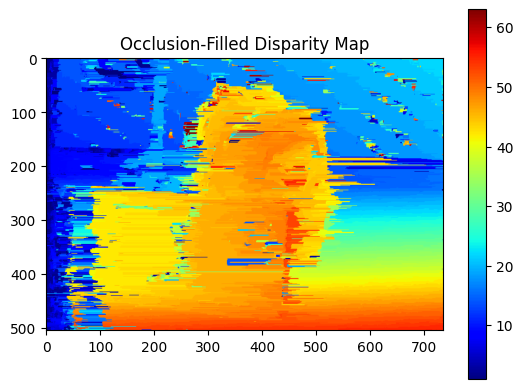

In [11]:
import numpy as np

def occlusion_filling(disparity_map):
    """Fill occluded pixels (zeros) with nearest valid disparity."""
    h, w = disparity_map.shape
    filled = np.copy(disparity_map)
    valid_mask = (disparity_map != 0)

    # Forward fill (left to right)
    for y in range(h):
        last_valid = 0
        for x in range(w):
            if valid_mask[y, x]:
                last_valid = disparity_map[y, x]
            else:
                filled[y, x] = last_valid

    # Backward fill (right to left)
    for y in range(h):
        last_valid = 0
        for x in reversed(range(w)):
            if valid_mask[y, x]:
                last_valid = disparity_map[y, x]
            else:
                # Choose the closest valid value between forward and backward
                if last_valid != 0:
                    if filled[y, x] == 0 or (abs(x - np.where(valid_mask[y, :x])[0][-1]) > abs(np.where(valid_mask[y, x:])[0][0] - x)):
                        filled[y, x] = last_valid

    # Vertical fill for remaining invalid pixels
    for y in range(h):
        for x in range(w):
            if filled[y, x] == 0:
                # Search upwards and downwards
                for dy in [-1, 1]:
                    ky = y + dy
                    if 0 <= ky < h and filled[ky, x] != 0:
                        filled[y, x] = filled[ky, x]
                        break

    return filled


# After cross-checking, apply occlusion filling
disp_filled = occlusion_filling(disp_combined)

# Visualize
plt.imshow(disp_filled, cmap='jet')
plt.colorbar()
plt.title('Occlusion-Filled Disparity Map')
plt.savefig("disp_filled.png", dpi=300, bbox_inches='tight')
plt.show()

# Stereo Disparity code from ChatGPT

In [8]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import cv2

def compute_zncc(patch1, patch2):
    """
    Compute the zero-mean normalized cross-correlation (ZNCC) between two patches.

    Parameters:
      patch1, patch2: 2D numpy arrays representing the image patches.

    Returns:
      ZNCC score (a float). If the denominator is zero, returns a very low score.
    """
    patch1 = patch1.astype(np.float32)
    patch2 = patch2.astype(np.float32)

    mean1 = np.mean(patch1)
    mean2 = np.mean(patch2)

    # Compute the numerator of ZNCC
    numerator = np.sum((patch1 - mean1) * (patch2 - mean2))
    # Compute the denominator: product of the L2 norms (standard deviation factors)
    denom = np.sqrt(np.sum((patch1 - mean1)**2) * np.sum((patch2 - mean2)**2))

    # Avoid division by zero
    if denom == 0:
        return -1e9  # Return a very low score if the patch has no variation.

    return numerator / denom

def compute_disparity_map(left_img, right_img, max_disp, window_size):
    """
    Compute the disparity map using a sliding window and ZNCC for stereo matching.

    Parameters:
      left_img, right_img: Grayscale images as 2D numpy arrays.
      max_disp: Maximum disparity to search.
      window_size: Size of the window (must be an odd number).

    Returns:
      disparity_map: A 2D numpy array with the best disparity value for each valid pixel.
    """
    H, W = left_img.shape
    half_win = window_size // 2
    disparity_map = np.zeros_like(left_img, dtype=np.float32)

    # Process only pixels where a full window can be extracted from both images.
    for y in range(half_win, H - half_win):
        # Optional: print progress for each row to monitor execution.
        print(f"Processing row {y} of {H - half_win}")
        # The x-range starts from (max_disp + half_win) to ensure the right image patch is within bounds.
        for x in range(max_disp + half_win, W - half_win):
            best_zncc = -1e9  # Initialize with a very low value.
            best_disp = 0

            # Extract the patch from the left image centered at (x, y)
            left_patch = left_img[y - half_win : y + half_win + 1, x - half_win : x + half_win + 1]

            # For each disparity value, extract the corresponding patch from the right image.
            for d in range(max_disp):
                # Ensure the right patch is within bounds.
                if x - d - half_win < 0:
                    continue
                right_patch = right_img[y - half_win : y + half_win + 1, x - d - half_win : x - d + half_win + 1]
                zncc = compute_zncc(left_patch, right_patch)

                # Use Winner-Takes-All: choose the disparity with maximum ZNCC value.
                if zncc > best_zncc:
                    best_zncc = zncc
                    best_disp = d

            disparity_map[y, x] = best_disp
    return disparity_map

def normalize_disparity(disparity_map, max_disp):
    """
    Normalize the disparity map to the 0-255 range for visualization.

    Parameters:
      disparity_map: 2D numpy array of disparity values.
      max_disp: The maximum disparity value used in computation.

    Returns:
      A uint8 numpy array scaled to 0-255.
    """
    norm_disp = (disparity_map / max_disp) * 255.0
    norm_disp = np.clip(norm_disp, 0, 255)
    return norm_disp.astype(np.uint8)

def main():
    # Load stereo images. Replace 'left.png' and 'right.png' with the actual file paths.
    left_image = "/content/drive/MyDrive/Colab Notebooks/Multiprocessor Programming/im0.png"
    right_image = "/content/drive/MyDrive/Colab Notebooks/Multiprocessor Programming/im1.png"
     # Load images using cv2.imread
    left_img = cv2.imread(left_image)
    right_img = cv2.imread(right_image)

    left_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    right_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY) # Convert to grayscale

    # Convert images to floating-point numpy arrays.
    left_img = np.array(left_img, dtype=np.float32)
    right_img = np.array(right_img, dtype=np.float32)

    # Resize for testing (original size: 2940x2016 (WxH) -> 735x504)
    left_img = cv2.resize(left_img, (735, 504))
    right_img = cv2.resize(right_img, (735, 504))

    # Set stereo matching parameters.
    max_disp = 64    # Maximum disparity to search (example value; adjust based on your calibration and image scale)
    window_size = 9  # Window size (e.g., 9x9 window for matching)

    print("Computing disparity map...")
    disp_map = compute_disparity_map(left_img, right_img, max_disp, window_size)

    # Normalize the disparity map for display.
    norm_disp = normalize_disparity(disp_map, max_disp)

    # Display the left image, right image, and the resulting disparity map.
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Left Image")
    plt.imshow(left_img, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Right Image")
    plt.imshow(right_img, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Disparity Map")
    plt.imshow(norm_disp, cmap='gray')
    plt.axis('off')

    plt.show()

    # Optionally, save the disparity map.
    imageio.imwrite('disparity_map.png', norm_disp)
    print("Disparity map saved as 'disparity_map.png'.")

if __name__ == '__main__':
    main()


Computing disparity map...
Processing row 4 of 500
Processing row 5 of 500
Processing row 6 of 500
Processing row 7 of 500
Processing row 8 of 500
Processing row 9 of 500
Processing row 10 of 500
Processing row 11 of 500
Processing row 12 of 500
Processing row 13 of 500
Processing row 14 of 500
Processing row 15 of 500
Processing row 16 of 500
Processing row 17 of 500
Processing row 18 of 500
Processing row 19 of 500
Processing row 20 of 500
Processing row 21 of 500
Processing row 22 of 500
Processing row 23 of 500
Processing row 24 of 500
Processing row 25 of 500
Processing row 26 of 500
Processing row 27 of 500
Processing row 28 of 500
Processing row 29 of 500
Processing row 30 of 500
Processing row 31 of 500
Processing row 32 of 500
Processing row 33 of 500
Processing row 34 of 500
Processing row 35 of 500
Processing row 36 of 500
Processing row 37 of 500
Processing row 38 of 500
Processing row 39 of 500
Processing row 40 of 500
Processing row 41 of 500
Processing row 42 of 500
Proc

KeyboardInterrupt: 